# SPIDER CALIBRATION

## Imports

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass

import scipy.signal
import scipy.optimize

## Constants

In [62]:
# path to data files
DATA_PATH = "./data/"

# path to energy plots
E_PLOT_PATH = "./plots/energy-plots/"

# path to calibration plots
CALIB_PLOT_PATH = "./plots/calib-plots/"

# reference energies
E_CM = 5805
E_AM = 5486
E_PU = 5155

# digitizers
BOARD_1_ID = 2
BOARD_2_ID = 3
BOARD_3_ID = 4
BOARD_4_ID = 5

# strips
STRIP_1_ID = 0
STRIP_2_ID = 1
STRIP_3_ID = 2
STRIP_4_ID = 3
STRIP_5_ID = 4
STRIP_6_ID = 5
STRIP_7_ID = 6

# channels
STARTING_CHANNEL = 0
N_CHANNELS_BOARD = 16
N_CHANNELS_STRIP = 8

# energy filters
E_MIN = 3000
E_MAX = 4000

# plot stuff
FONTSIZE = 14

# save figure flag
SAVE_FIG = False

## Functions

In [4]:
def plot_strip_channels(
    df,
    channel,
    fig, 
    idx    = 1, 
    nrows  = 2, 
    ncols  = 4,
    bins   = 200,
    label  = "",
    ecolor = "#06416D", 
    fcolor = "#7eb0d5",
):
    ax = fig.add_subplot(nrows, ncols, idx)
    
    ax.hist(
        df.loc[(df["strip_ch"]==channel), "energy"], 
        bins      = bins, 
        histtype  = "stepfilled", 
        edgecolor = ecolor, 
        facecolor = fcolor,
        label     = label
    )
    
    return ax

def customize_plot(
    ax, 
    fontsize = 16, 
    xleft    = None, 
    xright   = None, 
    ydown    = None, 
    yup      = None,
    title    = "Energy spectrum",
    ylabel   = "Counts",
    xlabel   = "Energy"
):
    
    ax.set_title(title,   fontsize = fontsize+2)
    ax.set_ylabel(ylabel, fontsize = fontsize)
    ax.set_xlabel(xlabel, fontsize = fontsize)
    
    ax.set_ylim(bottom = ydown, top   = yup)
    ax.set_xlim(left   = xleft, right = xright)
    
    ax.tick_params(axis="both", which="major", labelsize=fontsize, length=5)
    
    return ax


def filter_energy(df, emin = 3000, emax = 4000):
    return df.loc[((df["energy"] > 3000) & (df["energy"] < 4000)), ]

def make_binning(df, bins):
    hist, edges = np.histogram(df.loc[:, "energy"], bins=bins)
    centers = (edges[1:] + edges[:-1]) / 2
    return centers, hist, edges

def plot_binned_hist(
    x,
    h,
    fig, 
    idx    = 1, 
    nrows  = 1, 
    ncols  = 1,
    bins   = 200,
    label  = None,
    ecolor = "#06416D", 
    fcolor = "#7eb0d5",
):
    ax = fig.add_subplot(nrows, ncols, idx)
    
    ax.hist(
        x, 
        weights   = h,
        bins      = bins, 
        histtype  = "stepfilled", 
        edgecolor = ecolor, 
        facecolor = fcolor,
        label     = label
    )
    
    return ax

def gaussian(x, n, u, s):
    return n*np.exp(- 0.5 * ( (x-u)/s )**2)

def linear(x, a, b):
    return a + b*x

## Data

In [5]:
@dataclass
class DataFormat:
    """Holds the structure of the .root file"""
    
    root_tree : str = "Data_R"
    
    channel   : str = "Channel"
    board     : str = "Board"
    flag      : str = "Flags"
    time      : str = "Timestamp"
    energy    : str = "Energy"
    
    @property
    def to_channel(self):
        return f"{self.root_tree}/{self.channel}"
    
    @property
    def to_board(self):
        return f"{self.root_tree}/{self.board}"
    
    @property
    def to_flag(self):
        return f"{self.root_tree}/{self.flag}"
    
    @property
    def to_time(self):
        return f"{self.root_tree}/{self.time}"
    
    @property
    def to_energy(self):
        return f"{self.root_tree}/{self.energy}"

In [6]:
data_fname  = "DataR_run_1.root"
data_format = DataFormat()

with uproot.open(f"{DATA_PATH}/{data_fname}") as data_file:
    channels = data_file[data_format.to_channel].array().to_numpy()
    boards   = data_file[data_format.to_board].array().to_numpy()
    flags    = data_file[data_format.to_flag].array().to_numpy()
    time     = data_file[data_format.to_time].array().to_numpy()
    energy   = data_file[data_format.to_energy].array().to_numpy()

df = pd.DataFrame({"board":boards, "channel":channels, "flag":flags, "timestamp":time, "energy":energy})

# create a strip tag
df.loc[((df["board"] == BOARD_1_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_1_ID
df.loc[((df["board"] == BOARD_1_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_2_ID
df.loc[((df["board"] == BOARD_2_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_3_ID
df.loc[((df["board"] == BOARD_2_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_4_ID
df.loc[((df["board"] == BOARD_3_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_5_ID
df.loc[((df["board"] == BOARD_3_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_6_ID
df.loc[((df["board"] == BOARD_4_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_7_ID

# create a strip channel tag ranging from 0 to 7
for strip_id in range(7):
    df.loc[(df["strip"] == strip_id), "strip_ch"] = df.loc[(df["strip"] == strip_id), "channel"] - df.loc[(df["strip"] == strip_id), "channel"].unique().max() + N_CHANNELS_STRIP - 1

# convert tags to small integers
df = df.astype({"strip": "int8", "strip_ch": "int8"})

## Strip 1

In [7]:
s = 1

df_1 = df.loc[(df["strip"] == STRIP_1_ID), ]

# filter
df_1_filtered = filter_energy(df_1, E_MIN, E_MAX)

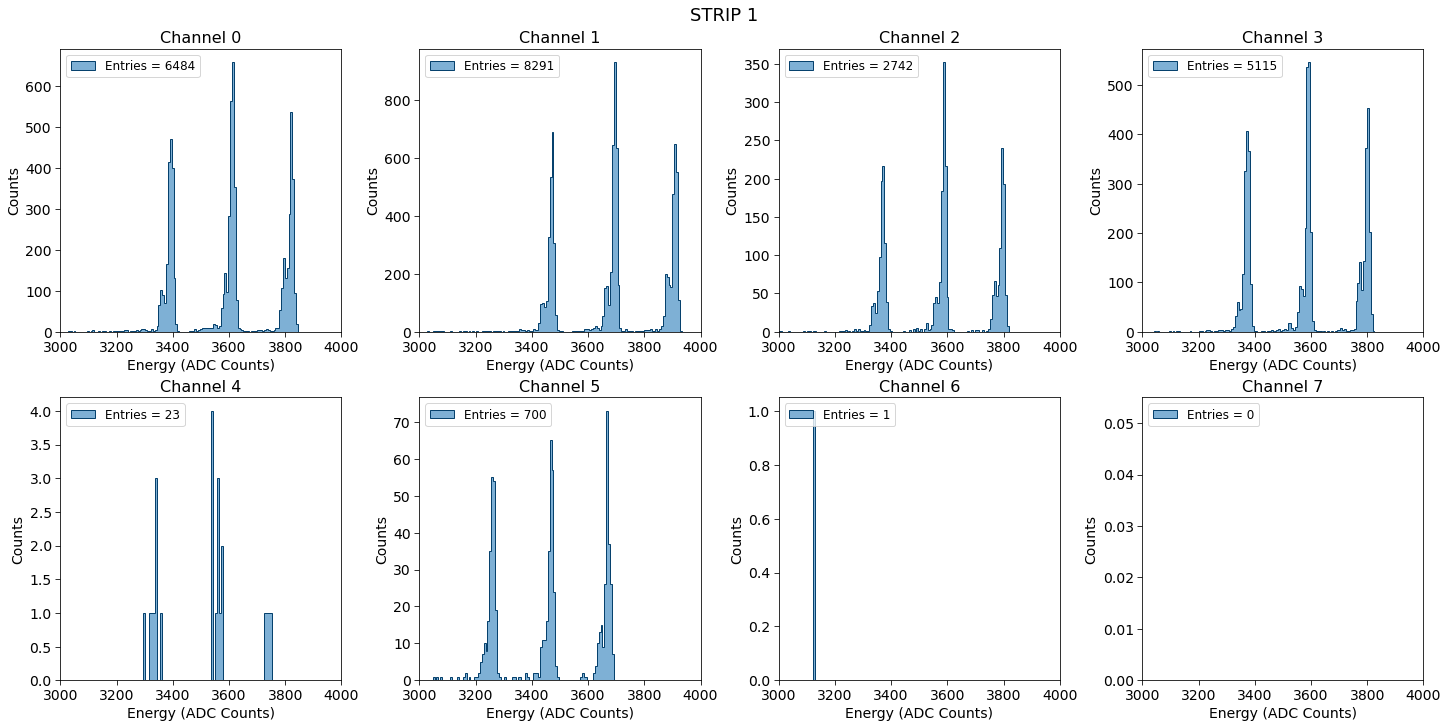

In [8]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle("STRIP 1", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_1_filtered.loc[(df_1_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_1_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{s}.png", dpi=300, facecolor="white")

plt.show()

## Strip 2

In [9]:
s = 2

df_2 = df.loc[(df["strip"] == STRIP_2_ID), ]

# filter
df_2_filtered = filter_energy(df_2, E_MIN, E_MAX)

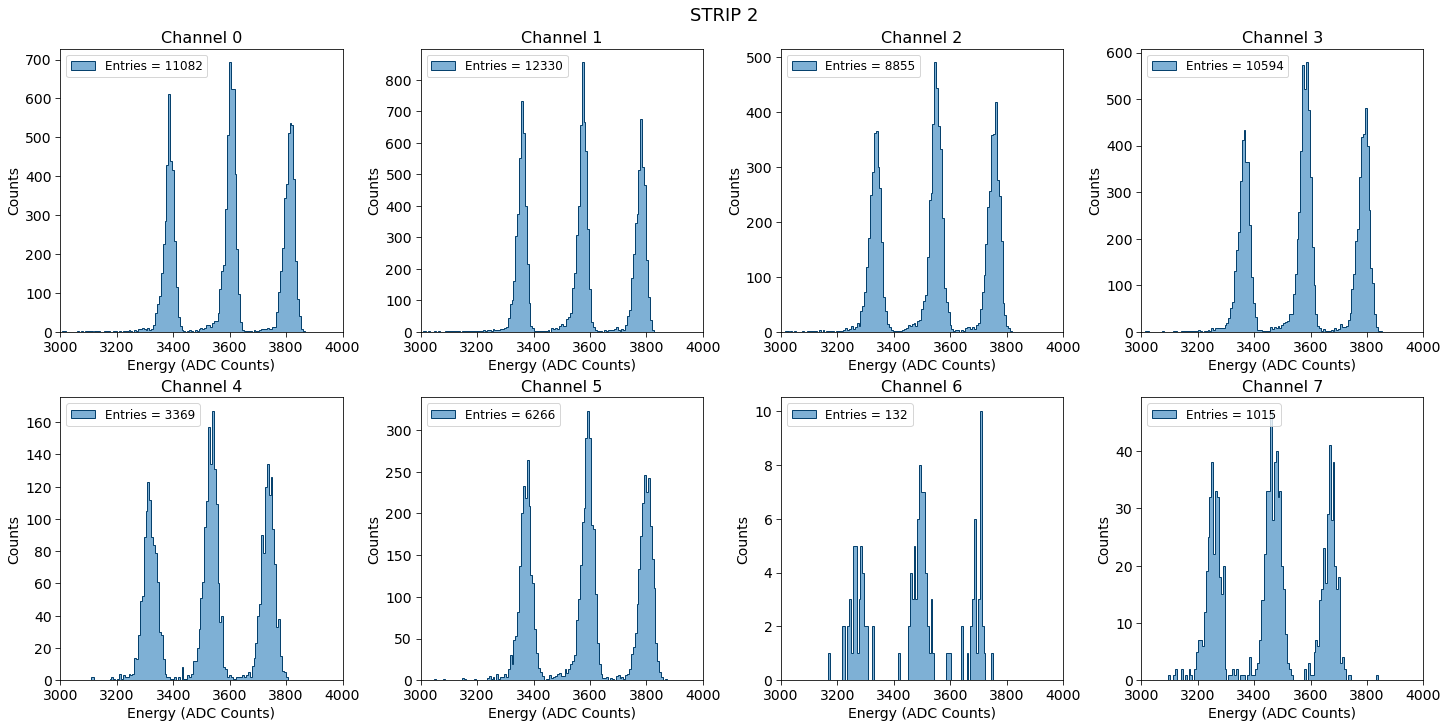

In [10]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle("STRIP 2", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_2_filtered.loc[(df_2_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_2_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{s}.png", dpi=300, facecolor="white")
    
plt.show()

## Strip 3

In [11]:
s = 3

df_3 = df.loc[(df["strip"] == STRIP_3_ID), ]

# filter
df_3_filtered = filter_energy(df_3, E_MIN, E_MAX)

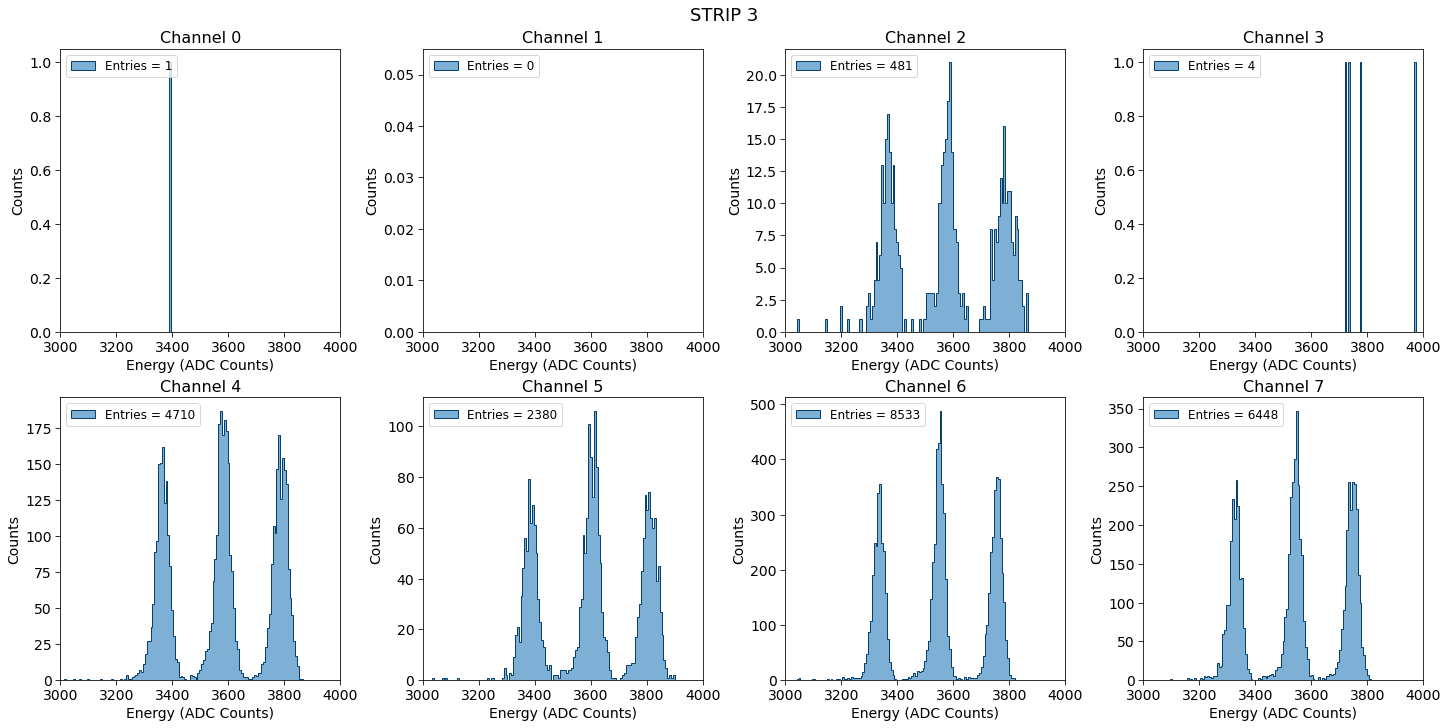

In [12]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle("STRIP 3", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_3_filtered.loc[(df_3_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_3_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{s}.png", dpi=300, facecolor="white")
    
plt.show()

## Strip 4

In [13]:
s = 4

df_4 = df.loc[(df["strip"] == STRIP_4_ID), ]

# filter
df_4_filtered = filter_energy(df_4, E_MIN, E_MAX)

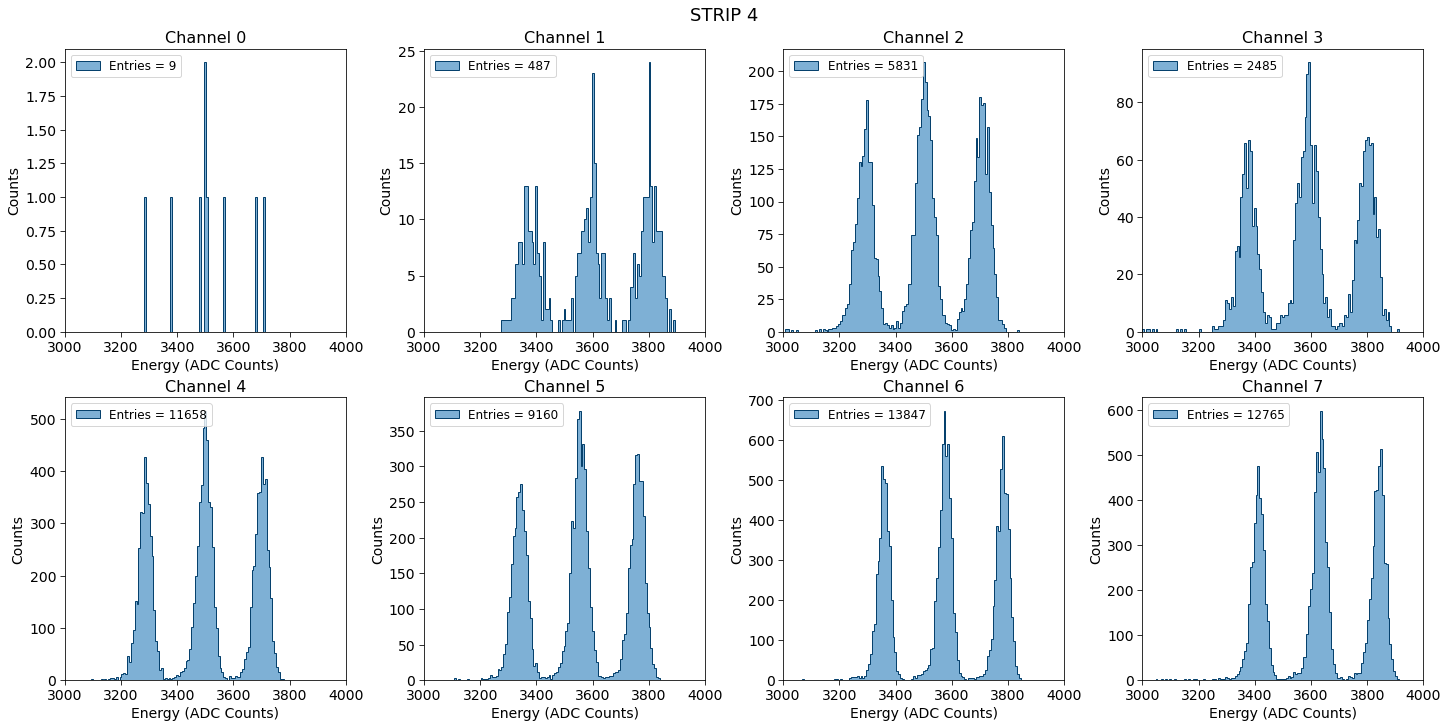

In [14]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle("STRIP 4", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_4_filtered.loc[(df_4_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_4_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{s}.png", dpi=300, facecolor="white")
    
plt.show()

## Strip 5

In [15]:
s = 5

df_5 = df.loc[(df["strip"] == STRIP_5_ID), ]

# filter
df_5_filtered = filter_energy(df_5, E_MIN, E_MAX)

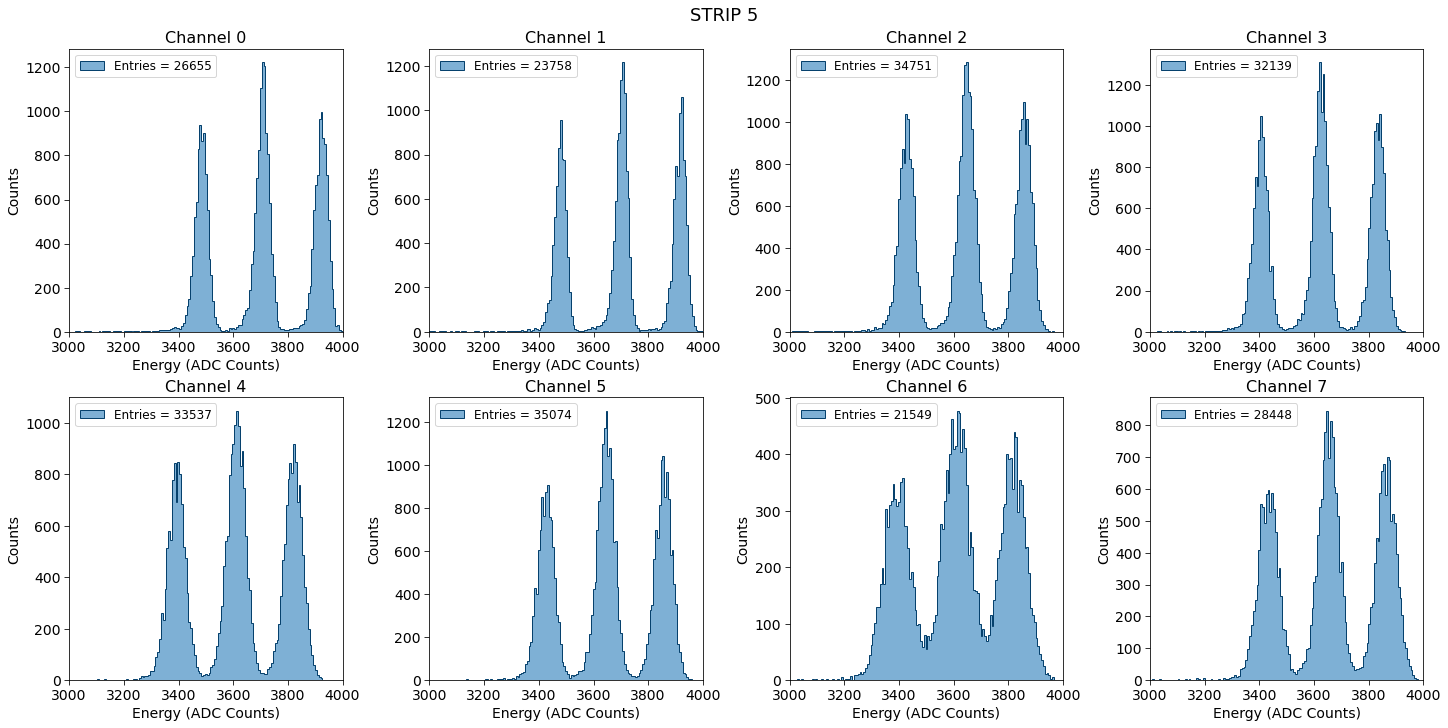

In [16]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle("STRIP 5", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_5_filtered.loc[(df_5_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_5_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{s}.png", dpi=300, facecolor="white")
    
plt.show()

## Strip 6

In [17]:
s = 6

df_6 = df.loc[(df["strip"] == STRIP_6_ID), ]

# filter
df_6_filtered = filter_energy(df_6, E_MIN, E_MAX)

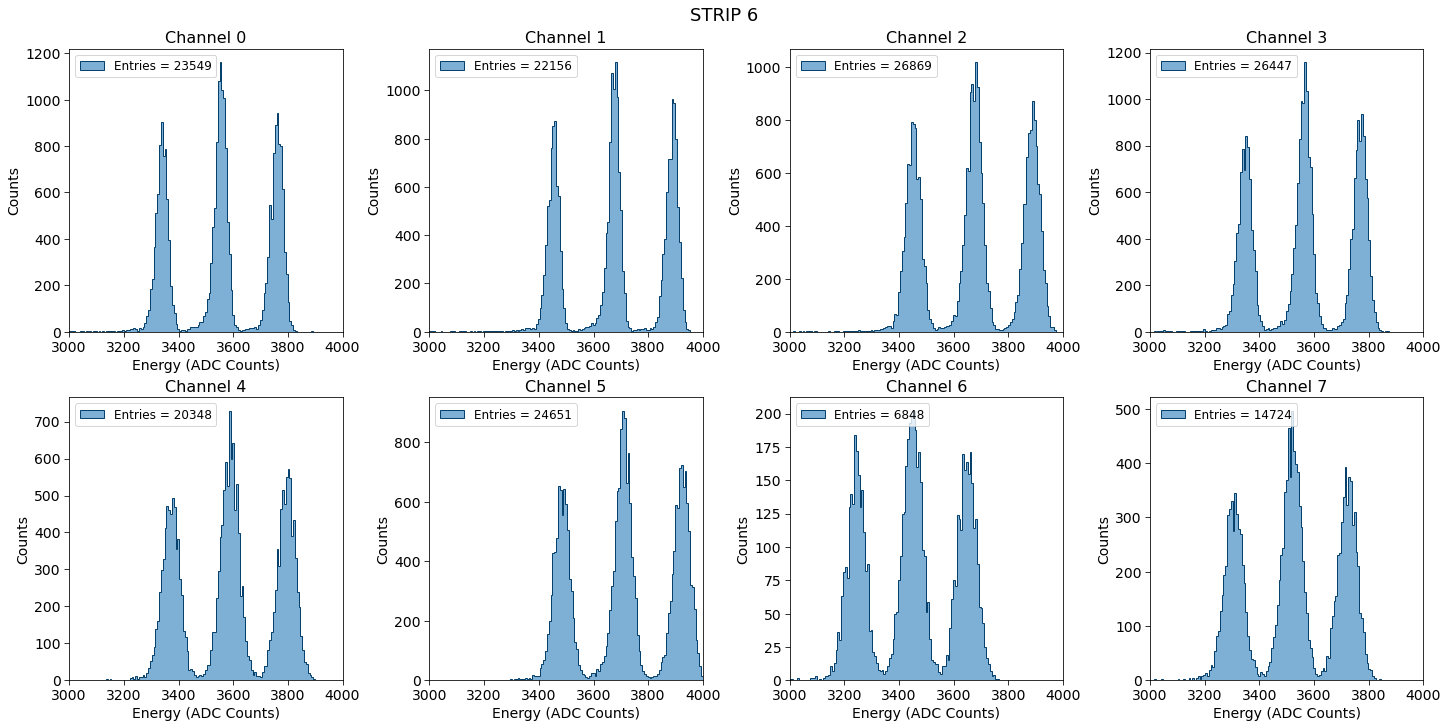

In [18]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle("STRIP 6", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_6_filtered.loc[(df_6_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_6_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{s}.png", dpi=300, facecolor="white")
    
plt.show()

## Strip 7

In [19]:
s = 7

df_7 = df.loc[(df["strip"] == STRIP_7_ID), ]

# filter
df_7_filtered = filter_energy(df_7, E_MIN, E_MAX)

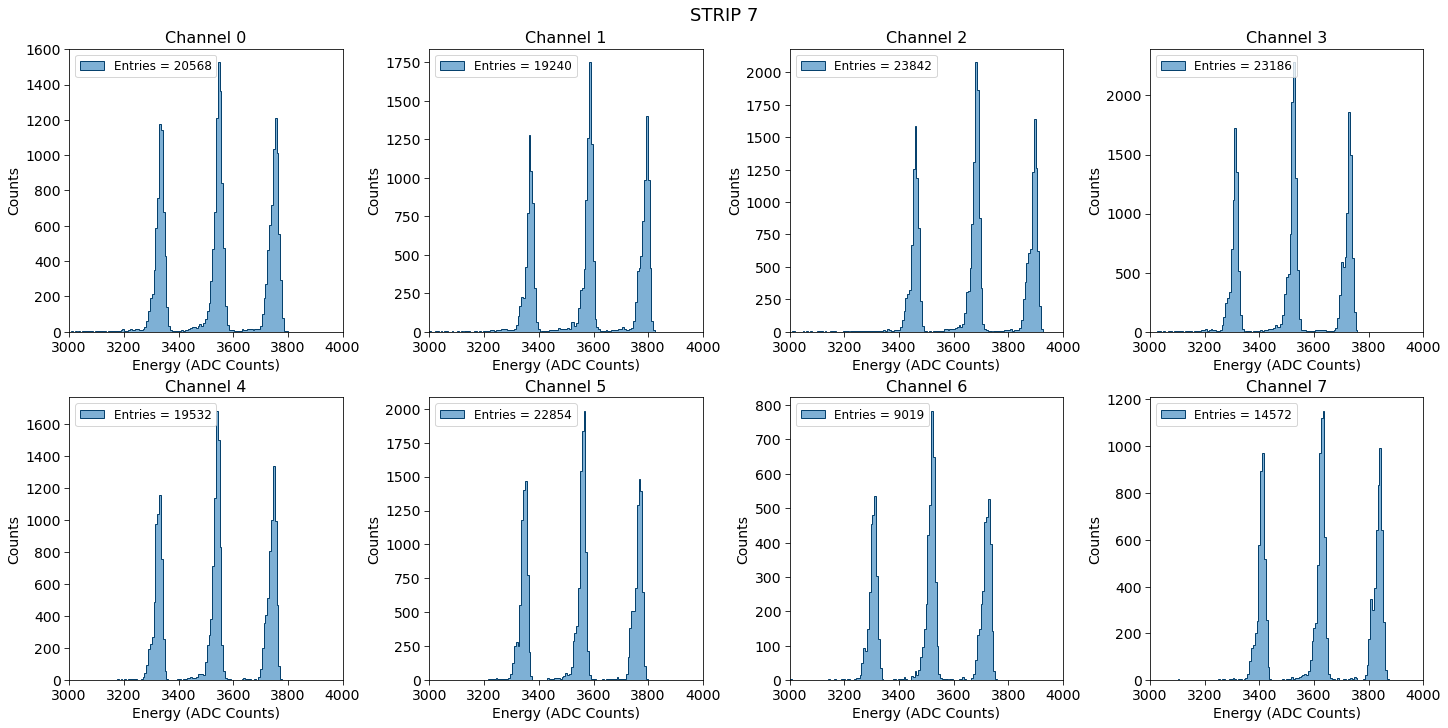

In [20]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle("STRIP 7", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_7_filtered.loc[(df_7_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_7_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{s}.png", dpi=300, facecolor="white")
    
plt.show()

## Calibration test

### good calibration

In [21]:
strip   = STRIP_7_ID
channel = 6

emin = 3200
emax = 3800

df_calib = filter_energy(df.loc[((df["strip"] == strip) & (df["strip_ch"] == channel)), ],  emin, emax)

In [55]:
n_entries = df_calib.shape[0]

bins = np.linspace(emin, emax, 150)

x, h, e = make_binning(df_calib, bins)

continuous_x = np.linspace(emin, emax, 1000)

# err_h = np.ones_like(h)
err_h = np.sqrt(h)
err_h[h==0] = 1

peaks, prop = scipy.signal.find_peaks(x = h, prominence=100)

norms      = []
means      = []
sigmas     = []
err_norms  = []
err_means  = []
err_sigmas = []
chisqs     = []

restrictions = [
    (22, 30),
    (15, 25),
    (15, 24)
]

for i, x_peak in enumerate(x[peaks]):
    left_base  = x[prop["left_bases"][i]]
    right_base = x[prop["right_bases"][i]]

    approx_width = (right_base - left_base) / 2

    fit_restriction = (x > x_peak - restrictions[i][0]) & (x < x_peak + restrictions[i][1])
    
    par, cov = scipy.optimize.curve_fit(
        f     = gaussian, 
        xdata = x[fit_restriction],
        ydata = h[fit_restriction],
        p0    = [n_entries/3, x_peak, approx_width],
        sigma = err_h[fit_restriction],
        absolute_sigma=True,
    )
    
    par_err = []
    for j in range(len(par)):
        try:
            par_err.append(np.absolute(cov[j][j])**0.5)
        except Exception:
            par_err.append( 0.00 )

    res   = h - gaussian(x, *par)
    chisq = np.sum((res / err_h)**2)

    norms.append(par[0])
    means.append(par[1])
    sigmas.append(np.abs(par[2]))
    err_norms.append(par_err[0])
    err_means.append(par_err[1])
    err_sigmas.append(par_err[2])
    chisqs.append(chisq)

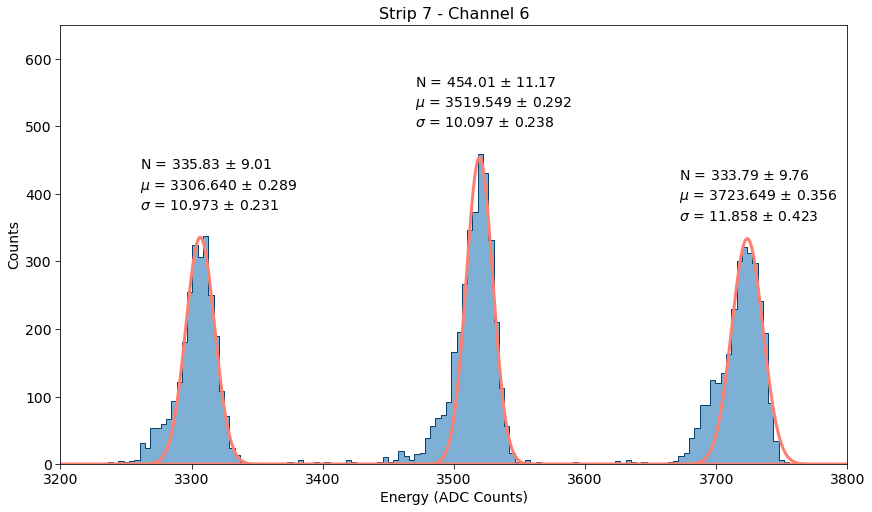

In [56]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_binned_hist(
    x     = x, 
    h     = h, 
    bins  = bins, 
    fig   = fig, 
    label = f"Entries = {n_entries}"
)

# ax.legend(loc="upper left", fontsize=FONTSIZE-2)

ax = customize_plot(
    ax       = ax, 
    fontsize = FONTSIZE,
    title    = f"Strip {strip+1} - Channel {channel}",
    ylabel   = "Counts",
    xlabel   = "Energy (ADC Counts)",
    xleft    = emin, 
    xright   = emax, 
    ydown    = 0,
    yup      = 650
)

# plot gaussians
for i, x_peak in enumerate(x[peaks]):
    
    left_base  = x[prop["left_bases"][i]]
    right_base = x[prop["right_bases"][i]]
    plot_restriction = (continuous_x > x_peak - restrictions[i][0]) & (continuous_x < x_peak + restrictions[i][1])
    
    ax.plot(continuous_x, gaussian(continuous_x, norms[i], means[i], sigmas[i]), color="#fd7f6f", lw=3)
    

    ax.text(x_peak - 50, prop["prominences"][i] + 100, f"N = {norms[i]:.2f} $\pm$ {err_norms[i]:.2f}",          transform=ax.transData, fontsize = FONTSIZE)
    ax.text(x_peak - 50, prop["prominences"][i] + 70,  f"$\mu$ = {means[i]:.3f} $\pm$ {err_means[i]:.3f}",      transform=ax.transData, fontsize = FONTSIZE)
    ax.text(x_peak - 50, prop["prominences"][i] + 40,  f"$\sigma$ = {sigmas[i]:.3f} $\pm$ {err_sigmas[i]:.3f}", transform=ax.transData, fontsize = FONTSIZE)

    
if SAVE_FIG:
    fig.savefig(f"{CALIB_PLOT_PATH}/e-strip{strip+1}channel{channel}.png", dpi=300, facecolor="white")
    
plt.show()

spostare left fit del primo picco un po piu a destra

valore assoluto sulle sigma

allungare right fit dell'ultimo picco

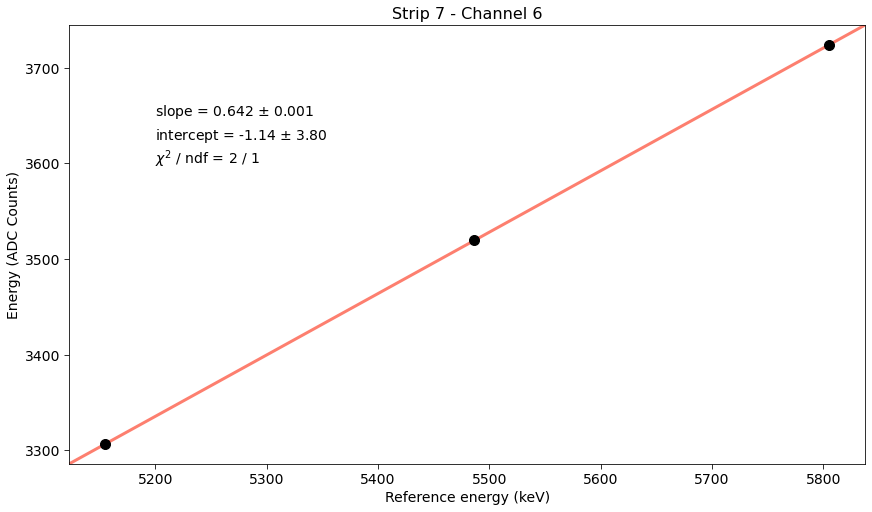

In [65]:
true_means = np.sort([E_AM, E_CM, E_PU])
true_means_continuous = np.linspace(5*1e3, 6*1e3, 1000)

plin, clin = scipy.optimize.curve_fit(f=linear, xdata=true_means, ydata=means, sigma=err_means, absolute_sigma=True)

plin_err = []
for j in range(len(plin)):
    try:
        plin_err.append(np.absolute(clin[j][j])**0.5)
    except Exception:
        plin_err.append( 0.00 )

res   = means - linear(true_means, *plin)
chisq = np.sum((res / err_means)**2)

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = fig.add_subplot(111)

ax.errorbar(
    x          = true_means, 
    y          = means, 
    yerr       = err_means, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "black"
)

ax = customize_plot(
    ax       = ax, 
    fontsize = FONTSIZE,
    title    = f"Strip {strip+1} - Channel {channel}",
    ylabel   = "Energy (ADC Counts)",
    xlabel   = "Reference energy (keV)",
    # xleft    = emin, 
    # xright   = emax, 
    # ydown    = 0,
    # yup      = 650
)

ax.plot(true_means_continuous, plin[0]+plin[1]*true_means_continuous, color="#fd7f6f", lw=3)


ax.text(5.2*1e3, 3650, f"slope = {plin[1]:.3f} $\pm$ {plin_err[1]:.3f}", transform=ax.transData, fontsize = FONTSIZE)
ax.text(5.2*1e3, 3625, f"intercept = {plin[0]:.2f} $\pm$ {plin_err[0]:.2f}", transform=ax.transData, fontsize = FONTSIZE)
ax.text(5.2*1e3, 3600, f"$\chi^2$ / ndf = {chisq:.0f} / 1", transform=ax.transData, fontsize = FONTSIZE)

if SAVE_FIG:
    fig.savefig(f"{CALIB_PLOT_PATH}/calib-strip{strip+1}channel{channel}.png", dpi=300, facecolor="white")

plt.show()

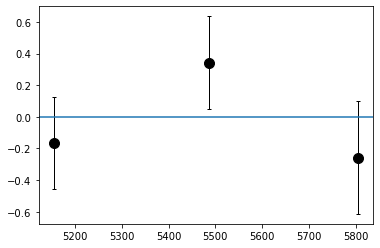

In [70]:
plt.errorbar(
    x          = true_means, 
    y          = res, 
    yerr       = err_means, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "black"
)

plt.axhline(y=0)
plt.show()